In [1]:
import glob
import numpy as np
import os
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator
import tensorflow as tf

from matplotlib import pyplot as plt
import seaborn as sns


/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2023-07-26 01:16:02.024606: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 01:16:02.233274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 01:16:03.113112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def convert_tb_data(root_dir, sort_by=None, exp_name=''):
    """Convert local TensorBoard data into Pandas DataFrame.
    
    Function takes the root directory path and recursively parses
    all events data.    
    If the `sort_by` value is provided then it will use that column
    to sort values; typically `wall_time` or `step`.
    
    *Note* that the whole data is converted into a DataFrame.
    Depending on the data size this might take a while. If it takes
    too long then narrow it to some sub-directories.
    
    Paramters:
        root_dir: (str) path to root dir with tensorboard data.
        sort_by: (optional str) column name to sort by.
    
    Returns:
        pandas.DataFrame with [wall_time, name, step, value] columns.
    
    """

    def convert_tfevent(filepath):
        return pd.DataFrame([
            parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)
        ])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tf.make_ndarray(tfevent.summary.value[0].tensor)),
        )
    
    columns_order = ['wall_time', 'name', 'step', 'value']
    
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by is not None:
        all_df = all_df.sort_values(sort_by)

    all_df.name = all_df.name.apply(lambda name: exp_name + "/" + name)
        
    return all_df.reset_index(drop=True)

def plot_category(df, category_name, interpolate=True, interval_window=100, compute_ewm=True, ewm_alpha=0.25):
    category_df = df[df.name.str.endswith(category_name)]
    category_df.index.name = 'index'
    
    assert category_df.shape[0] > 0, "Invalid category '%s'" % category_name

    if interpolate:
        index_name = 'step'
        interpolated_df = pd.DataFrame(columns=['value', 'name'])
        interpolated_df.index.name = index_name

        # get names of folders
        names = category_df.name.unique()

        # Re sample rewards by fix intervals for comparison between different runs
        for name in names:
            intervals = np.arange(0, int(category_df['step'].iloc[-1])+1, interval_window)
            name_df = category_df.loc[category_df.name == name]
            interval_df = name_df.groupby(pd.cut(name_df['step'], intervals, labels=intervals[1:]))['value'].mean().interpolate().fillna(value=0.0).to_frame()
            interval_df['name'] = name
            interpolated_df = pd.concat([interpolated_df, interval_df])
    else:
        index_name = 'index'
        interpolated_df = category_df

    plot_data = None
    if compute_ewm:
        # Compute exponential moving average (smoothing)
        groups = interpolated_df.groupby('name')
        ewm_df = groups.value.ewm(alpha=ewm_alpha).mean().reset_index().set_index(index_name).rename(columns={"value":"ewm"})
        postprocessing_df = pd.merge(interpolated_df, ewm_df, how='left', left_on=[index_name, 'name'], right_on=[index_name, 'name'])
        postprocessing_df.ewm = postprocessing_df["ewm"]
        plot_data = 'ewm'
        plot_df = postprocessing_df
    else:
        plot_data = 'value'
        plot_df = interpolated_df

    # Plot by aggregaring runs with common name
    indicator = interpolated_df.name.apply(lambda name: name.split("__")[0]).to_numpy()
    sns.lineplot(data=plot_df, x="step", y=plot_data, hue=indicator)

In [3]:
root_directory = "/root/trufus/clean_results/"
root_directory = "/root/o2ac-ur/clean_results/Disect/"

directory_list = glob.glob(root_directory + "*/")
print(directory_list)

csv_list = glob.glob(root_directory + "*.csv")
print(csv_list)


['/root/o2ac-ur/clean_results/Disect/SAC_disect_slicing_3d-S.046559/', '/root/o2ac-ur/clean_results/Disect/SAC_disect_slicing_3d-S.523613/']
[]


In [4]:
all_data = []
for dir in directory_list:
    exp_name = dir.split("/")[-2]
    print(exp_name)
    all_data.append(convert_tb_data(dir, sort_by="step", exp_name=exp_name))
# for csv_file in csv_list:
#     all_data.append(pd.read_csv(csv_file))

df = pd.concat(all_data)

SAC_disect_slicing_3d-S.046559
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
SAC_disect_slicing_3d-S.523613


2.0.3


(0.0, 150.0)

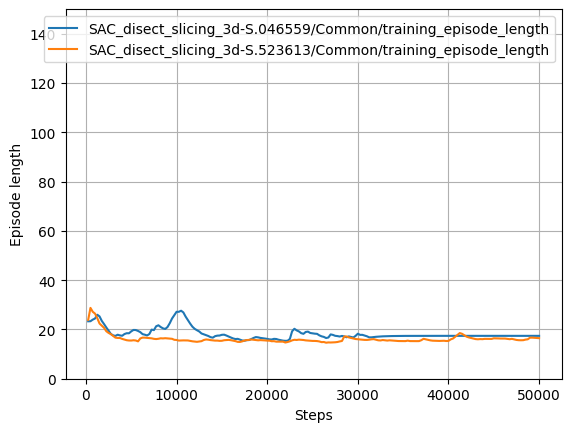

In [5]:
import pandas
print(pandas.__version__)
plot_category(df, "training_episode_length", ewm_alpha=0.2, interval_window=250)
plt.title("")
plt.ylabel("Episode length")
plt.xlabel("Steps")
plt.grid()
plt.ylim(0, 35)

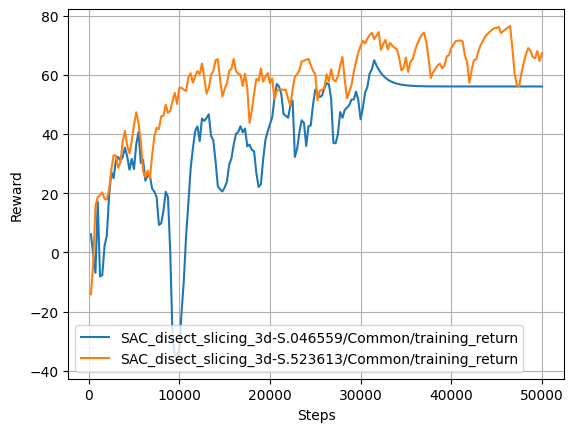

In [6]:
plot_category(df, "training_return", ewm_alpha=0.2, interval_window=250)
plt.title("")
plt.ylabel("Reward")
plt.xlabel("Steps")
plt.grid()
# plt.ylim(0, 75)

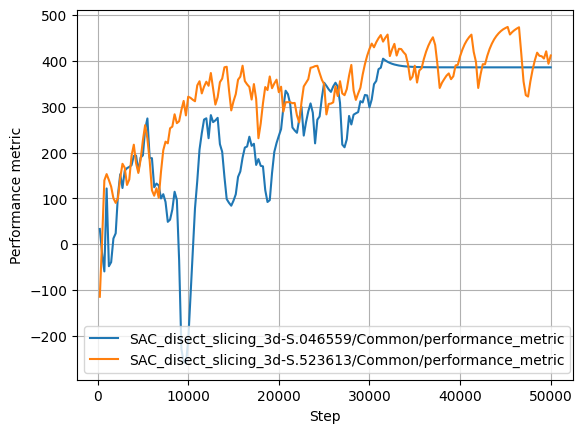

In [7]:
plot_category(df, "performance_metric", compute_ewm=True, ewm_alpha=0.2, interval_window=250)
plt.title("")
plt.ylabel("Performance metric")
plt.xlabel("Step")
plt.grid()
# plt.ylim(-80, -10)